In [152]:
import numpy as np
import pandas as pd
import math
import cv2
import os
import random
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from pathlib import Path
import shapely
from shapely.wkt import loads as wkt_loads
from shapely.geometry import MultiPolygon, Polygon
import tifffile as tiff
from tqdm import tqdm
import collections

import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.layers import Input, Conv2D, Convolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Dropout, concatenate, merge
from keras.initializers import he_normal
from keras.models import Model
from tensorflow.keras.optimizers import Adam


In [38]:
# constants
SIZE_CHUNK = 160
CLASS_AMOUNT = 10
THRESHOLDS = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
BASE_PATH = "./prepared_data/"
DATA_PATH = "./data"
SMOOTH = 1e-12
EPOCHS = 10


In [39]:
TR = pd.read_csv(Path(DATA_PATH) / 'train_wkt_v4.csv')
GS = pd.read_csv(Path(DATA_PATH) / 'grid_sizes.csv')
GS = GS.rename(columns={'Unnamed: 0': 'ImageId'})
SB = pd.read_csv(Path(DATA_PATH) / 'sample_submission.csv')


In [5]:
TR


,ImageId,ClassType,MultipolygonWKT
0,6040_2_2,1,MULTIPOLYGON EMPTY
1,6040_2_2,2,MULTIPOLYGON EMPTY
2,6040_2_2,3,MULTIPOLYGON EMPTY
3,6040_2_2,4,MULTIPOLYGON (((0.003025 -0.007879000000000001...
4,6040_2_2,5,MULTIPOLYGON (((0.005311 -0.009044999999999999...
...,...,...,...
245,6100_2_2,6,"MULTIPOLYGON (((0.006102 -0.009042, 0.00642 -0..."
246,6100_2_2,7,MULTIPOLYGON (((0.007887999999999999 -0.009042...
247,6100_2_2,8,"MULTIPOLYGON (((0.002119 -0.001417, 0.002132 -..."
248,6100_2_2,9,"MULTIPOLYGON (((0.008021 -0.003252, 0.00803399..."


In [92]:
len(TR.ImageId.unique())


25

In [6]:
GS


,ImageId,Xmax,Ymin
0,6120_2_4,0.009180,-0.009040
1,6120_2_3,0.009169,-0.009040
2,6120_2_2,0.009188,-0.009040
3,6120_2_1,0.009188,-0.009040
4,6120_2_0,0.009188,-0.009040
...,...,...,...
445,6130_1_4,0.009169,-0.009040
446,6130_1_3,0.009188,-0.009040
447,6130_1_2,0.009150,-0.009042
448,6130_1_1,0.009004,-0.009045


In [91]:
len(GS.ImageId.unique())


450

In [40]:
SB

,ImageId,ClassType,MultipolygonWKT
0,6120_2_4,1,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
1,6120_2_4,2,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
2,6120_2_4,3,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
3,6120_2_4,4,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4,6120_2_4,5,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
...,...,...,...
4285,6130_1_0,6,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4286,6130_1_0,7,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4287,6130_1_0,8,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."
4288,6130_1_0,9,"POLYGON ((0 0, 0.009188 0, 0.009188 -0.0090399..."


In [10]:
def adjust_image(bands, lower_percent=2, higher_percent=98):
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0
        b = 1
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t

    return out.astype(np.float32)


In [11]:
def coords_to_raster(coords, img_size, xmax, ymax):
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / xmax
    yf = H1 / ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int


In [12]:
def convert_contours(polygon_list, raster_img_size, xmax, ymin):
    interior_list = []
    exterior_list = []
    if polygon_list is None:
        return None
    for poly in polygon_list:
        perim = np.array(list(poly.exterior.coords))
        rastered_perim = coords_to_raster(perim, raster_img_size, xmax, ymin)
        exterior_list.append(rastered_perim)
        for poly_interiors in poly.interiors:
            interor = np.array(list(poly_interiors.coords))
            rastered_interor = coords_to_raster(
                interor, raster_img_size, xmax, ymin)
            interior_list.append(rastered_interor)
    return exterior_list, interior_list


In [13]:
def generate_mask(raster_size, img_id, class_type):
    xmax, ymin = GS[GS.ImageId == img_id].iloc[0, 1:].astype(float)
    df_image = TR[TR.ImageId == img_id]
    multipolygon = df_image[df_image.ClassType == class_type].MultipolygonWKT
    polygon_list = None
    polygon_values = multipolygon.values[0]
    if polygon_values != "MULTIPOLYGON EMPTY":
        polygon_list = wkt_loads(polygon_values)

    contours = convert_contours(polygon_list, raster_size, xmax, ymin)
    img_mask = np.zeros(raster_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, 1)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


In [14]:
def augment_and_pack_image(img, mask, dataset_type, augment_amount, augment=True):
    borderline_x, borderline_y = img.shape[0] - \
        SIZE_CHUNK, img.shape[1] - SIZE_CHUNK
    #split_amount = int(augment_amount * 0.1)
    #augment_amount -= split_amount
    #non_augment_amount = split_amount

    x_dataset_augmented = []
    y_dataset_augmented = []
    # x_dataset_non_augmented = []
    # y_dataset_non_augmented = []

    Path(f"{BASE_PATH}{'x_' + dataset_type}").mkdir(parents=True, exist_ok=True)
    Path(f"{BASE_PATH}{'y_' + dataset_type}").mkdir(parents=True, exist_ok=True)

    if augment:
        Path(f"{BASE_PATH}{'x_augm_' + dataset_type}").mkdir(parents=True, exist_ok=True)
        Path(f"{BASE_PATH}{'y_augm_' + dataset_type}").mkdir(parents=True, exist_ok=True)

        for idx in range(augment_amount):
            rnd_x = np.random.randint(0, borderline_x)
            rnd_y = np.random.randint(0, borderline_y)
            chunk_img = img[rnd_x:rnd_x + SIZE_CHUNK, rnd_y:rnd_y + SIZE_CHUNK]
            chunk_mask = mask[rnd_x:rnd_x +
                              SIZE_CHUNK, rnd_y:rnd_y + SIZE_CHUNK]

            for cls_type in range(CLASS_AMOUNT):
                mask_sum = np.sum(chunk_mask[:, :, cls_type])
                if mask_sum / (SIZE_CHUNK ** 2) > THRESHOLDS[cls_type]:
                    # reverse
                    if np.random.uniform(0, 1) > 0.5:
                        chunk_img = chunk_img[::-1]
                        chunk_mask = chunk_mask[::-1]

                    # flip
                    if np.random.uniform(0, 1) > 0.5:
                        chunk_img = chunk_img[:, ::-1]
                        chunk_mask = chunk_mask[:, ::-1]

                    rotation = np.random.randint(4)
                    # rotate
                    if np.random.uniform(0, 1) > 0.5:
                        chunk_img = np.rot90(chunk_img, k=rotation)
                        chunk_mask = np.rot90(chunk_mask, k=rotation)

                    # shear
                    if np.random.uniform(0, 1) > 0.5:
                        chunk_img = tf.keras.preprocessing.image.apply_affine_transform(
                            chunk_img)
                        chunk_mask = tf.keras.preprocessing.image.apply_affine_transform(
                            chunk_mask)

                chunk_img = chunk_img.astype(np.float32)
                chunk_mask = chunk_mask.astype(np.float32)

                #chunk_img = chunk_img.rollaxis

                np.save(
                    f"{BASE_PATH}{'x_augm_' + dataset_type}/{idx}_{cls_type}", chunk_img)
                np.save(
                    f"{BASE_PATH}{'y_augm_' + dataset_type}/{idx}_{cls_type}", chunk_mask)

                x_dataset_augmented.append(
                    f"{BASE_PATH}{'x_augm_' + dataset_type}/{idx}_{cls_type}.npy")
                y_dataset_augmented.append(
                    f"{BASE_PATH}{'y_augm_' + dataset_type}/{idx}_{cls_type}.npy")

    # for idx in range(non_augment_amount):
    #     rnd_x = np.random.randint(0, borderline_x)
    #     rnd_y = np.random.randint(0, borderline_y)
    #     chunk_img = img[rnd_x:rnd_x + SIZE_CHUNK, rnd_y:rnd_y + SIZE_CHUNK]
    #     chunk_mask = mask[rnd_x:rnd_x + SIZE_CHUNK, rnd_y:rnd_y + SIZE_CHUNK]

    #     np.save(f"{BASE_PATH}{'x_' + dataset_type}/{idx}", chunk_img)
    #     np.save(f"{BASE_PATH}{'y_' + dataset_type}/{idx}", chunk_mask)

    #     x_dataset_non_augmented.append(
    #         f"{BASE_PATH}{'x_' + dataset_type}/{idx}.npy")
    #     y_dataset_non_augmented.append(
    #         f"{BASE_PATH}{'y_' + dataset_type}/{idx}.npy")

    # return x_dataset_augmented + x_dataset_non_augmented, y_dataset_augmented + y_dataset_non_augmented
    return x_dataset_augmented, y_dataset_augmented


def load_prepared(filenames_x, filenames_y):
    images = [np.load(image)
              for image in filenames_x]
    masks = [np.load(mask)
             for mask in filenames_y]
    return images, masks

def get_dataset_filenames(dataset_type):

    def get_filenames(path):
        filenames = next(
        os.walk(f"{BASE_PATH}{path}"), (None, None, []))[2]
        filenames = [Path(f"{BASE_PATH}{path}") / filename for filename in filenames]
        return filenames

    filenames_x_augm = get_filenames(f"{'x_augm_' + dataset_type}")
    filenames_x = get_filenames(f"{'x_' + dataset_type}")

    filenames_y_augm = get_filenames(f"{'y_augm_' + dataset_type}")
    filenames_y = get_filenames(f"{'y_' + dataset_type}")

    return filenames_x + filenames_x_augm, filenames_y + filenames_y_augm




In [15]:
ids = sorted(set(TR.ImageId))
images = []

for id in ids:
    rgb_img = os.path.join(Path(DATA_PATH) / 'sixteen_band', f'{id}_M.tif')
    rgb_img = tiff.imread(rgb_img)
    rgb_img = np.rollaxis(rgb_img, 0, 3)
    img = adjust_image(rgb_img).copy()
    images.append(img)
images = np.array(images)


<ipython-input-15-e290109545f4>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


In [35]:
min_image_shape = np.array([np.array(image.shape)[:-1]
                           for image in images]).min()
bands_amount = images[0].shape[-1]
square_size = int(len(ids) ** (1/2))
print(min_image_shape, bands_amount, square_size)

835 8 5


In [36]:
max_image_shape = np.array([np.array(image.shape)[:-1]
                           for image in images]).max()
max_image_shape                           

851

In [17]:
pxls_size = int(square_size * min_image_shape)
X = np.zeros((pxls_size, pxls_size, bands_amount))
Y = np.zeros((pxls_size, pxls_size, CLASS_AMOUNT))

for row in range(square_size):
    for col in range(square_size):
        img = images[row * square_size + col]
        id = ids[row * square_size + col]
        X[min_image_shape * row:min_image_shape * row + min_image_shape, min_image_shape *
            col:min_image_shape * col + min_image_shape, :] = img[:min_image_shape, :min_image_shape, :]
        for cls_type in range(CLASS_AMOUNT):
            Y[min_image_shape * row:min_image_shape * row + min_image_shape, min_image_shape * col:min_image_shape * col +
                min_image_shape, cls_type] = generate_mask(img.shape[:-1], id, cls_type + 1)[:min_image_shape, :min_image_shape]


In [266]:
x_train, y_train = augment_and_pack_image(X, Y, "train", 8000)

In [18]:
x_train, y_train = get_dataset_filenames("train")

In [ ]:
#x_train, y_train = load_prepared(*download_prepared("train"))

In [272]:
x_test, y_test = augment_and_pack_image(X, Y, "test", 3000)


In [21]:
x_test, y_test = get_dataset_filenames("test")

In [ ]:
#x_test, y_test = load_prepared(download_prepared("test"))

In [273]:
x_valid, y_valid = augment_and_pack_image(X, Y, "valid", 3000)

In [22]:
x_valid, y_valid = get_dataset_filenames("valid")

In [ ]:
#x_valid, y_valid = load_prepared(download_prepared("valid"))

In [23]:
class Dataset():
    def __init__(self, images_dir, mask_dir):
        self.images_frames = images_dir
        self.mask_frames = mask_dir

    def __getitem__(self, idx):
        image = np.load(self.images_frames[idx])
        mask = np.load(self.mask_frames[idx])

        #image = np.rollaxis(image, 2, 0)
        #mask = np.rollaxis(mask, 2, 0)

        return image, mask
    
    def __len__(self):
        return len(self.images_frames)


class Dataloader(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        images = []
        masks = []
        for idx in range(start, end):
            images.append(self.dataset[idx][0])
            masks.append(self.dataset[idx][1])

        return np.array(images), np.array(masks)

    def __len__(self):
        return math.ceil(len(self.dataset) / self.batch_size)

In [24]:
train_dataset = Dataset(x_train, y_train)
train_dataloader = Dataloader(train_dataset, batch_size=8)

valid_dataset = Dataset(x_valid, y_valid)
valid_dataloader = Dataloader(valid_dataset, batch_size=8)

In [570]:
image, mask = train_dataloader.__getitem__(0)

In [25]:
def jaccard_coef(y_true, y_pred):
    """
    Jaccard Index: Intersection over Union.
    J(A,B) = |A∩B| / |A∪B| 
         = |A∩B| / |A|+|B|-|A∩B|
    """
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    total = K.sum(y_true + y_pred, axis=[0, -1, -2])
    union = total - intersection

    jac = (intersection + SMOOTH) / (union + SMOOTH)

    return K.mean(jac)


In [26]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


def get_unet():

    inputs = Input((SIZE_CHUNK, SIZE_CHUNK, 8))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(CLASS_AMOUNT, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy',
                  metrics=[jaccard_coef])

    return model


In [27]:
checkpoint_filepath = './checkpoint_weight/weights-{epoch:02d}-{jaccard_coef:.4f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)


In [28]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)


In [29]:
early_srop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3)


In [30]:
model = get_unet()

In [491]:
images = np.array([image, image])
masks = np.array([mask, mask])

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16034962727004276884
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4158062592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5602444130307472967
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [31]:
model.fit(train_dataloader, epochs=EPOCHS, validation_data=(valid_dataloader), callbacks=[
          model_checkpoint_callback, tensorboard_callback, early_srop_callback])


Epoch 1/10
10000/10000 [==============================] - ETA: 0s - loss: 0.0955 - jaccard_coef: 0.2922
Epoch 00001: val_loss improved from inf to 0.07007, saving model to ./checkpoint_weight\weights-01-0.2922.hdf5
10000/10000 [==============================] - 1006s 97ms/step - loss: 0.0955 - jaccard_coef: 0.2922 - val_loss: 0.0701 - val_jaccard_coef: 0.3883
Epoch 2/10
10000/10000 [==============================] - ETA: 0s - loss: 0.0662 - jaccard_coef: 0.4150
Epoch 00002: val_loss improved from 0.07007 to 0.06003, saving model to ./checkpoint_weight\weights-02-0.4150.hdf5
10000/10000 [==============================] - 979s 98ms/step - loss: 0.0662 - jaccard_coef: 0.4150 - val_loss: 0.0600 - val_jaccard_coef: 0.4273
Epoch 3/10
10000/10000 [==============================] - ETA: 0s - loss: 0.0584 - jaccard_coef: 0.4551
Epoch 00003: val_loss improved from 0.06003 to 0.05548, saving model to ./checkpoint_weight\weights-03-0.4551.hdf5
10000/10000 [==============================] - 948s 95

KeyboardInterrupt: 

In [167]:

def mask_to_polygons(mask, epsilon=5, min_area=1.):
    contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = collections.defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons

In [28]:
test_dataset = Dataset(x_test, y_test)
test_dataloader = Dataloader(test_dataset, batch_size=1)

In [44]:
model.load_weights("./checkpoint_weight/weights-08-0.5266.hdf5")

In [148]:
def predict_by_id(id, model):
    rgb_img = os.path.join(Path(DATA_PATH) / 'sixteen_band', f'{id}_M.tif')
    rgb_img = tiff.imread(rgb_img)
    rgb_img = np.rollaxis(rgb_img, 0, 3)
    img = adjust_image(rgb_img).copy()

    num_of_chunks = 6
    max_size = SIZE_CHUNK * num_of_chunks
    cnv = np.zeros((max_size, max_size, 8)).astype(np.float32)
    prd = np.zeros((CLASS_AMOUNT, max_size, max_size)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = img
    
    for i in range(0, num_of_chunks):
        line = []
        for j in range(0, num_of_chunks):
            line.append(cnv[i * SIZE_CHUNK:(i + 1) * SIZE_CHUNK, j * SIZE_CHUNK:(j + 1) * SIZE_CHUNK])

        tmp = model.predict(np.array(line), batch_size=4)
        tmp = np.transpose(tmp, (0, 3, 1, 2))
        for j in range(tmp.shape[0]):
            prd[:, i * SIZE_CHUNK:(i + 1) * SIZE_CHUNK, j * SIZE_CHUNK:(j + 1) * SIZE_CHUNK] = tmp[j]

    # trs = [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1]
    for i in range(CLASS_AMOUNT):
        prd[i] = prd[i] > THRESHOLDS[i]

    return prd[:, :img.shape[0], :img.shape[1]]

In [149]:
def predict_test(model):
    for i, id in enumerate(sorted(set(SB['ImageId'].tolist()))):
        msk = predict_by_id(id, model)
        np.save(f'./predicted/msk_{id}', msk)
        if i % 100 == 0: 
            print (i, id)

In [150]:
predict_test(model)

(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
0 6010_0_0
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)

In [151]:
def get_scalers(im_size, x_max, y_min):
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

In [162]:
def make_submit():
    df = pd.read_csv(os.path.join(Path(DATA_PATH) / 'sample_submission.csv'))
    for idx, row in df.iterrows():
        id = row[0]
        class_of_obj = row[1] - 1

        msk = np.load(f'./predicted/msk_{id}.npy')[class_of_obj]
        pred_polygons = mask_to_polygons(msk)
        x_max = GS.loc[GS['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GS.loc[GS['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
    df.to_csv('subm.csv', index=False)

In [168]:
make_submit()

NameError: name 'defaultdict' is not defined

In [134]:
predicted = predict_by_id("6100_2_2", model)

(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)
(6, 10, 160, 160)


In [139]:
predicted_t = np.transpose(predicted, (1, 2, 0))

In [140]:
predicted_t.shape

(837, 848, 10)

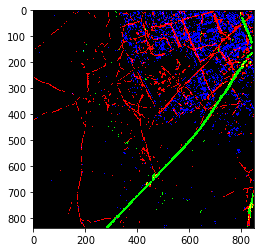

In [147]:
plot_image(predicted_t)

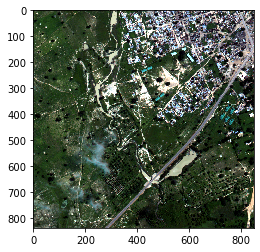

In [137]:
rgb_img = os.path.join(Path(DATA_PATH) / 'sixteen_band', "6100_2_2_M.tif")
rgb_img = tiff.imread(rgb_img)
rgb_img = np.rollaxis(rgb_img, 0, 3)
img = adjust_image(rgb_img).copy()
plot_image(img)

In [36]:
scores = []
for i in tqdm(range(2)):#tqdm(range(len(test_dataloader))):
    pred_mask = model.predict(test_dataloader[i][0])
    score = jaccard_coef(test_dataloader[i][1], pred_mask)
    scores.append(score)

100%|██████████| 2/2 [00:00<00:00,  2.68it/s]


In [146]:
def plot_image(image):
  #m = adjust_image(image)
  m = image
  img = np.zeros((m.shape[0],m.shape[1],3))
  img[:,:,0] = m[:,:,3] #red
  img[:,:,1] = m[:,:,2] #green
  img[:,:,2] = m[:,:,1] #blue
  #plt.figure(figsize=(7,7))
  plt.imshow(img, interpolation='nearest')
  plt.show()